# Benchmarking 2

Another important factor influencing system performance is the **cluster configuration**.  
In particular, the **number of workers** plays a central role in determining the computation speed of the algorithms, as it directly affects the degree of parallelization that can be achieved.  

In the following experiments, we keep both the dataset and the partition size fixed, while varying the number of workers.  
This allows us to isolate and study how performance changes as we scale the cluster.

In [ ]:
from functions import cholesky_tsqr, direct_tsqr, indirect_tsqr     # Import the functions


In [ ]:
import time
from time import sleep
from dask.distributed import Client, LocalCluster, wait
import numpy as np
import dask.array as da
import dask
from scipy.linalg import solve_triangular 
import matplotlib.pyplot as plt


### Local setup

For academic purposes, and to showcase some core Dask functionalities (e.g., the `cluster.scale()` method), we begin by working locally on a smaller dataset.  
This serves as a foundation for the more extensive study that will later be carried out on the Virtual Machine (VM) hosted on Cloud Veneto.  

In the local setup, we create a cluster with 4 processes: **3 workers** that handle computations and **1 scheduler** that coordinates them.

In [101]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

print("Dashboard:", client.dashboard_link)


/home/riccorte/miniconda3/envs/dask-env/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34337 instead
  warnings.warn(


Dashboard: http://127.0.0.1:34337/status


In [102]:
# check if everything went smoothly
cluster


LocalCluster(d6a88a62, 'tcp://127.0.0.1:42849', workers=4, threads=4, memory=5.79 GiB)

In the following, we download the California Housing dataset.  

Since our setup includes 4 VMs (1 master + 3 workers), and we plan to test performance with all possible numbers of workers (from 1 → 3), we select a fixed number of partitions equal to the least common multiple (LCM) of the worker counts.  
This ensures that the Dask environment can distribute the workload evenly and remain optimized across all the different cases, since an even divisibility is guaranteed and this the partitions are balanced across workers.


In [103]:
from sklearn.datasets import fetch_california_housing

# Download California Housing dataset
data = fetch_california_housing(as_frame=True)

# Convert features into Dask Array (it's a matrix).
n_partition = 6        
length_partition = data.data.shape[0] // n_partition
X_da = da.from_array(data.data.values, chunks=(length_partition, data.data.shape[1]))

print("Number of Dask partitions:",  X_da.npartitions) 
print("Length of each partition:", length_partition, "rows")
print("Length of the whole dataset:", data.data.shape[0], "rows")


Number of Dask partitions: 6
Length of each partition: 3440 rows
Length of the whole dataset: 20640 rows


Usually, to speed up computations, the dataset is persisted across workers. This way, subsequent functions can reuse the data directly from memory instead of re-reading it each time.

In our case, however, the number of workers changes between runs. If we persist the data too early, it will remain pinned to the initial set of workers, and defining a new number of workers won't work properly. To avoid this imbalance, we only persist after deciding the number of workers for each run, ensuring that the dataset is distributed correctly across the active workers.

In [ ]:
X_da


dask.array<array, shape=(20640, 8), dtype=float64, chunksize=(3440, 8), chunktype=numpy.ndarray>

In [105]:
def ensure_scaled(target, timeout):  # Number of workers, timeout to avoid waiting in the event of an error
    """
    This is the function that scales the cluster to scale to `target` workers and wait until they are ready.

    """

    # Ask the scheduler to scale up to `target` workers.
    cluster.scale(target)

    t0 = time.time()

    # This loop calls the dask scheduler periodically until the number of workers desired are match or we have a timeout
    while time.time() - t0 < timeout:
        info = client.scheduler_info()
        nworkers = len(info.get("workers", {}))

        if nworkers >= target:
            # We have at least `target` workers and we can return the number of workers we will be working with
            return nworkers
        sleep(0.5)

    # If we exit the loop then the timeout was reached
    # Return the number of workers were available
    return len(client.scheduler_info().get("workers", {}))


def print_workers_info():
    """
    Important function to keep up with the diagnoscti information about each worker in the cluster.

    Useful if scaling failed or jobs are hanging.
    """
    info = client.scheduler_info().get("workers", {})
    for addr, w in info.items():
        # Show worker address, threads, number of tasks currently processing,
        # And the memory limit allocated to that worker.
        print(
            addr,
            "nthreads:", w.get("nthreads"),
            "processing:", len(w.get("processing", {})),
            "memory:", w.get("memory_limit")
        )




def run_once(A, tsqr_func, timeout = 120): # We receive the dask array with the imput matrix already persisted, and the function to use
    """
    This is the function that runs the TSQR functions and measure the execution time.

    """

    t0 = time.time()
    # We get Q, R. Depending on the function used they might be passed as a delayed object or a dask array.
    Q, R = tsqr_func(A)

  
    if hasattr(R, "persist"):   # In case R is also a Dask object it is necessary to persist it otherwise it would remain lazy
        R = R.persist()
        wait(R, timeout=timeout)
        client.cancel(R)    # Cancel after timing to free worker memory and ensure consistent conditions across different runs
    
    if hasattr(Q, "persist"):
        Q = Q.persist()
        wait(Q, timeout=timeout)
        client.cancel(Q)

    t1 = time.time()
    return t1 - t0

def time_vs_workers(workers_list, funcs, reps=2): # List of the number of workers to work with 
    """
    Run benchmarks for multiple TSQR algorithms across different worker counts.
    This is the function that iterates the run_once across all the different desired cases

    """

    results = {name: {} for name in funcs}  # nested dictionary

    for w in workers_list:
        # Ask cluster to scale and wait for workers by calling the previous function
        actual = ensure_scaled(w, timeout=120)
        print(f"\nRequested {w}, actual available {actual}")
        print_workers_info()

        # Rechunk to balance work across `actual` workers
        # The idea is to always have 6 partitions (balanced across workers later by scheduler)
        n_rows = int(A0.shape[0])
        rows_per_chunk = (n_rows + 6 - 1) // 6   # ceil division for 6 chunks

        A = A0.rechunk((rows_per_chunk, -1)).persist()  # This follows the number "initial" partitions that we initialized earlier

        # Wait until array is fully materialized in worker memory
        wait(A, timeout=120)


        # Benchmark each algorithm
        for name, func in funcs.items():    # This is the function that iterates over all the different TSQR algorithms:

            # Perform multiple timed runs
            times = [run_once(A, func) for _ in range(reps)]

            # Save mean and standard deviation
            results[name][w] = (float(np.mean(times)), float(np.std(times)))
            print(f"{name}, w={w}: mean={results[name][w][0]:.3f}s std={results[name][w][1]:.3f}s")

        # Cancel persisted array so next iteration starts clean
        client.cancel(A)
        del A

    return results  # Nested dictionary with structure results[algorithm][workers] = (mean_time, std_time).




The **results** show that, for a dataset of this size, changing the number of workers does not significantly affect efficiency. This is expected: when the dataset is small, the *computational load of a single worker is already manageable*, and the overhead introduced by distributing tasks across multiple workers can offset the potential speedup.

Within this setup, the Cholesky TSQR emerges as the most efficient method, while the direct method performs slightly better than the indirect method. However, this behavior is strongly tied to the dataset size, and as it will be later shown: the indirect method only becomes advantageous as the dataset grows larger. 

The reason of this changes stand in how the two approaches distribute and combine their computations:

**Direct TSQR** requires each block to compute a local QR, followed by a second round of QR on the stacked intermediate R matrices. This creates a relatively large amount of intermediate data movement and synchronization. On small datasets this overhead is negligible, so the direct method performs well.

**Indirect TSQR**, instead, shifts more of the workload toward combining the much smaller R matrices. Its advantage is that the heavy computations (matrix multiplications with the global R⁻¹) scale better and avoid repeated QR decompositions. For small datasets this extra indirection is just overhead, but as the dataset grows, the relative cost of the QR steps in the direct method dominates, and the indirect method becomes more efficient.



We can also experience that, for such a small dataset, the **standard deviation** of the runtimes can be relatively high and oscillate significantly across runs. This variability is mainly due to the fact that the computational load is so light that external factors (e.g., scheduling overhead, communication latency, or background processes on the machine) become comparable in magnitude to the actual computation time.


Requested 1, actual available 3
tcp://127.0.0.1:46251 nthreads: 1 processing: 0 memory: 1554740224
indirect, w=1: mean=0.220s std=0.047s
direct, w=1: mean=0.162s std=0.010s
cholesky, w=1: mean=0.088s std=0.004s

Requested 2, actual available 2
tcp://127.0.0.1:46067 nthreads: 1 processing: 0 memory: 1554740224
tcp://127.0.0.1:46251 nthreads: 1 processing: 0 memory: 1554740224
indirect, w=2: mean=0.189s std=0.001s
direct, w=2: mean=0.151s std=0.009s
cholesky, w=2: mean=0.089s std=0.004s

Requested 3, actual available 3
tcp://127.0.0.1:42303 nthreads: 1 processing: 0 memory: 1554740224
tcp://127.0.0.1:46067 nthreads: 1 processing: 0 memory: 1554740224
tcp://127.0.0.1:46251 nthreads: 1 processing: 0 memory: 1554740224
indirect, w=3: mean=0.208s std=0.024s
direct, w=3: mean=0.158s std=0.009s
cholesky, w=3: mean=0.092s std=0.005s


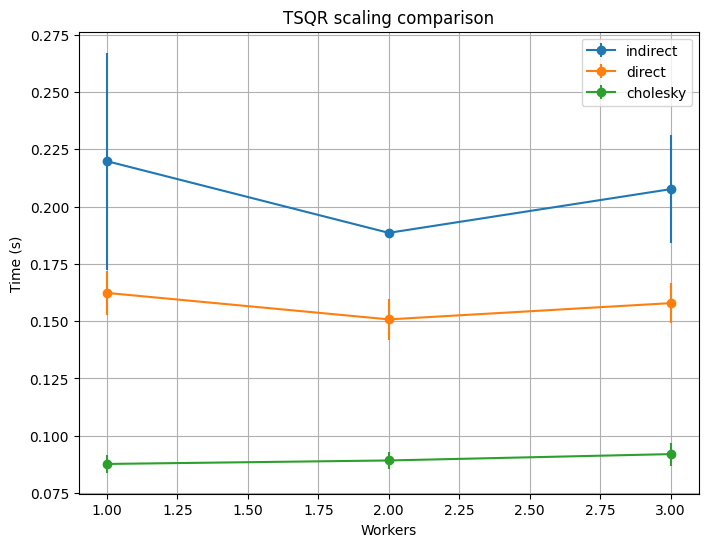

In [ ]:
funcs = {
    "indirect": indirect_tsqr,
    "direct": direct_tsqr,
    "cholesky": cholesky_tsqr,
}

workers_list = [1, 2, 3]  # This is the list of workers you will run with, for the local case the maximum number of workers availble is 3
scaling_results = time_vs_workers(workers_list, funcs, reps=10)



# Plot the results
plt.figure(figsize=(8,6))
for name, data in scaling_results.items():
    ws = sorted(data.keys())
    means = [data[w][0] for w in ws]
    stds = [data[w][1] for w in ws]

    # Error bars show variance across repetitions
    plt.errorbar(ws, means, yerr=stds, marker="o", label=name)

plt.xlabel("Workers")
plt.ylabel("Time (s)")
plt.title("TSQR scaling comparison")
plt.legend()
plt.grid(True)
plt.show()


Below we show a visualization of the Dask execution stream.
(Note: the image corresponds to a simplified run compared to the full system shown above, to make the structure easier to follow.)

In the stream plot we can see how tasks such as compute_R, get item, matmul, read, etc. are scheduled and executed. Each block corresponds to a task, and their colors represent different types of operations. These tasks are executed in parallel across the currently active workers.

Once the computations for a given configuration of workers are finished, the cluster is rescaled and a new round of computations begins.
As we have seen earlier the rescaling is achieved via the function `cluster.scale()`, which dynamically changes the number of active workers in the cluster. This allows us to test the same algorithms under different parallelization settings, without having to restart everything from scratch.

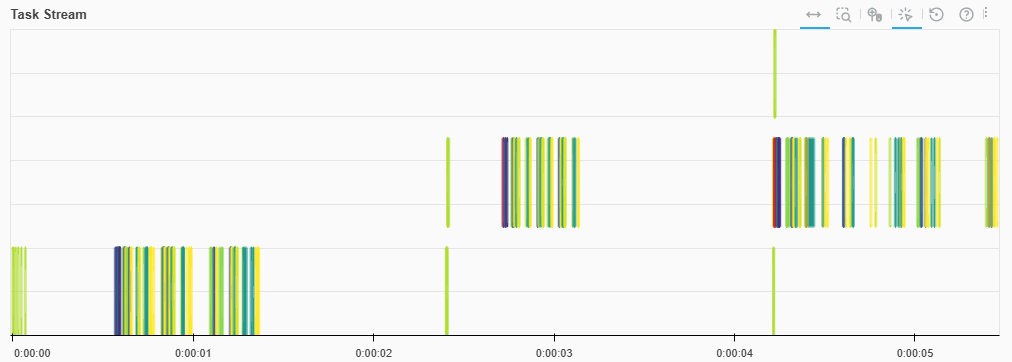

### New Clean Approach for SSH clusters:

We will now apply the previously described method to the larger **HIGGS dataset**.  

Compared to the earlier setup, one complication arises: the `cluster.scale()` function does not behave properly with **SSH clusters**.  
This is because SSHCluster requires an explicit specification of workers at creation time — workers cannot be dynamically scaled up or down with a simple integer argument, as this can corrupt the worker specification and lead to errors.  

To vary the number of workers, we therefore adopt a different approach:  
we repeatedly **stop and restart the cluster**, each time initializing it with a different number of workers.  
This allows us to systematically study performance while controlling the cluster size.


In [ ]:
from dask.distributed import SSHCluster, get_client


In [ ]:
import dask.dataframe as dd
import os

os.chdir("/home/ubuntu") 
path_HIGGS = os.getcwd() + "/datasets/HIGGS.csv"

df = dd.read_csv(path_HIGGS, header=None, blocksize="50MB")    # The block size is chosen accordingly to the previous benchmarking results
X_df = df.iloc[:, 1:] 
X_da = X_df.to_dask_array(lengths=True)   # We want it as a matrix (an array, that is)


In [ ]:
print(X_da)
A0 = X_da.rechunk((1_000_000, -1))
A0 = X_da


dask.array<read-_to_string_dtype-values, shape=(11000000, 28), dtype=float64, chunksize=(275002, 28), chunktype=numpy.ndarray>


In [ ]:
def run_once(A, tsqr_func, client, timeout=300): 
    """Run one TSQR variant once on A.
    Works even if functions return (Q, R) with mixed types or just R."""

    import time
    t0 = time.time()
    result = tsqr_func(A)

  
    Q, R = result
    if hasattr(R, "persist"):   # in case R is also a Dask object
        R = R.persist()
        wait(R, timeout=timeout)
        client.cancel(R)
    # Persist only if Dask objects
    if hasattr(Q, "persist"):
        Q = Q.persist()
        wait(Q, timeout=timeout)
        client.cancel(Q)

    t1 = time.time()
    return t1 - t0


Most of the following functions are directly ispired from the local approach with some modification to be coherent with the new method.

In [ ]:
def rechunk_mb(A0, chunks_per_worker=3, target_mb=50):
    """
    Rechunk A0 so each chunk is ~50 MB and at least `chunks_per_worker`
    per active worker. Then persist and rebalance across workers.
    """
    nworkers = max(1, len(client.scheduler_info().get("workers", {})))  # Get the number of workers via client.scheduler_info()
    n_rows   = int(A0.shape[0])
    n_cols   = int(A0.shape[1])
    bpe      = np.dtype(A0.dtype).itemsize  # bytes per element, tells how many bytes one entry of the matrix takes in memory

    # compute how many rows ~50 MB corresponds to
    rows_for_50mb = max(1, (target_mb * 1024**2) // (n_cols * bpe)) # target_mb * 1024**2 = target chunk size in bytes (e.g. 50 MB), (n_cols * bpe) = memory taken by one row

    # ensure enough chunks for load balancing
    n_chunks   = (n_rows + rows_for_50mb - 1) // rows_for_50mb  # ceiling division, number of chunks to get eactly 50 mb
    rows_per_chunk = (n_rows + n_chunks - 1) // n_chunks # ceiling division, how many rows per chunk

    # rechunk, persist into worker memory, and rebalance across workers
    A = A0.rechunk((rows_per_chunk, -1)).persist()  # Similarly as before we persist only after the number of workers have been defined
    wait(A)
    client.rebalance([A])
    return A


def benchmark_funcs(A, reps=3):
    """
    Run each TSQR variant (indirect, direct, cholesky) on A
    and return mean + std of runtimes over `reps` repetitions.
    """
    results = {}
    funcs = {
        "indirect": indirect_tsqr,
        "direct": direct_tsqr,
        "cholesky": cholesky_tsqr,
    }
    for name, func in funcs.items():
        times = [run_once(A, func, client) for _ in range(reps)]
        results[name] = (np.mean(times), np.std(times))
    return results


def run_scaling_experiment(hosts, worker_counts, reps=2):
    """
    For each value in worker_counts:
      - create a new SSHCluster with that many workers,
      - rechunk A0 for ~50 MB chunks,
      - benchmark all TSQR variants,
      - record mean + std runtime.
    """
    scaling_results = { "indirect": [], "direct": [], "cholesky": [] }

    for w in worker_counts:
        print(f"\n=== Running with {w} workers ===")

        # new cluster for each worker count
        cluster = SSHCluster(
            hosts,
            connect_options={"known_hosts": None},
            remote_python="/home/ubuntu/miniconda3/bin/python",
            worker_options={"n_workers": w, "nthreads": 1},
            scheduler_options={"port": 8786, "dashboard_address": ":8797"},
        )
        global client
        client = Client(cluster)

        # rebalance dataset across current workers
        A = rechunk_mb(A0, chunks_per_worker=3, target_mb=50)

        # run and store results
        results = benchmark_funcs(A, reps=reps)
        for name, (mean, std) in results.items():
            scaling_results[name].append((w, mean, std))

        # cleanup
        client.close()
        cluster.close()

    return scaling_results


We can observe that the function takes as an argument the number of workers to be used.  

This value does not directly correspond to the *exact* number of active workers.  
That's because when we define the clusters inside the function `run_scaling_experiment()`, the argument `n_workers` is internally multiplied by the number of available cores per machine.  

In our case, the Virtual Machine has **3 cores**, so the actual number of workers launched is always a multiple of 3.  
As a result, the benchmarking experiments are carried out on **3, 6, 9, and 12 active workers**.



------------------------------------------------------------------------------------------------------------------------------


The final results align well with our expectations: the **indirect method** proves to be more efficient than the direct method when working with larger datasets.  
Moreover, we observe that the system overall exhibits **lower standard deviations**, as random fluctuations become less significant when computations are distributed over a larger workload.  

Another key point is the effect of parallelization: for large datasets such as **HIGGS (≈20 GB)**, increasing the number of workers clearly improves performance. This is because a higher degree of parallelization reduces the per-worker computational load and allows better utilization of resources.  

However, such improvements cannot continue indefinitely. If we were to hypothetically increase the number of workers beyond our current limit, performance would continue to improve only up to a certain point. Beyond that threshold, we would expect to hit an **asymptote**, where adding more workers no longer yields significant speedups.  

As we saw earlier in the local environment, this saturation typically occurs when the **per-worker workload becomes too small** (e.g., only a few hundred MBs per worker), at which point overheads in communication, scheduling, and data shuffling dominate any gains from parallelism.  



=== Running with 1 workers ===

=== Running with 2 workers ===

=== Running with 3 workers ===

=== Running with 4 workers ===


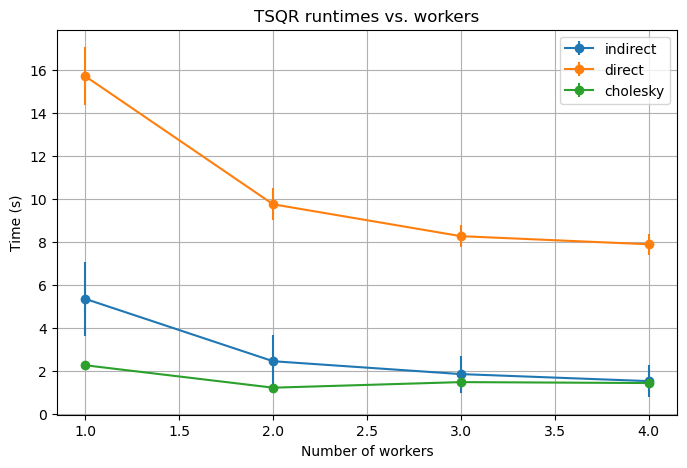

In [ ]:
hosts = ["10.67.22.154", "10.67.22.216", "10.67.22.116", "10.67.22.113"]
worker_counts = [1, 2, 3, 4]  
scaling_results = run_scaling_experiment(hosts, worker_counts, reps=2)


# Plot:
plt.figure(figsize=(8,5))
for name, data in scaling_results.items():
    ws, means, stds = zip(*data)
    plt.errorbar(ws, means, yerr=stds, marker="o", label=name)
plt.xlabel("Number of workers")
plt.ylabel("Time (s)")
plt.title("TSQR runtimes vs. workers")
plt.legend()
plt.grid(True)
plt.show()



Here We can see the Dask dashboard while the function was running, as expected the number of active workers changes dinamically and ranges from three up to twelve.

In [ ]:
client.close()
cluster.close()
